### Libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import dlc_bci as bci
from dlc_practical_prologue import *

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

import importlib
# customized libraries
import plot_lib as plib
import preprocess as prep


### Load dataset

In [2]:
# tr_input_org, tr_target_org = bci.load("bci", train=True, one_khz=True)
tr_input_org, tr_target_org = bci.load("bci", train=True, one_khz=False)
# te_input_org, te_target_org = bci.load("bci", train=False, one_khz=True)
te_input_org, te_target = bci.load("bci", train=False, one_khz=False)


tr_target_onehot = convert_to_one_hot_labels(tr_input_org, tr_target_org)
te_target_onehot = convert_to_one_hot_labels(te_input_org, te_target)

tr_target_onehot = Variable(tr_target_onehot)
te_target_onehot = Variable(te_target_onehot)

tr_target_org = Variable(tr_target_org)
te_target = Variable(te_target)

### Preprocessing - moving average / downsampling / DC blocker / DFT

In [3]:
importlib.reload(prep)
tr_input = tr_input_org.clone()
te_input = te_input_org.clone()
tr_target = tr_target_org.clone()

### Standardize

In [4]:
num_channel = tr_input.shape[1]
signal_len = tr_input.shape[2]

tr_input = torch.nn.functional.normalize(tr_input, p=2, dim=0) 
te_input = torch.nn.functional.normalize(te_input, p=2, dim=0) 

# Convert to 4D tensor [dataset size, number of channels, rows, cols]
tr_input = tr_input[:, np.newaxis, :, :]
te_input = te_input[:, np.newaxis, :, :]

tr_input = Variable(tr_input)
te_input = Variable(te_input)

### training

In [5]:
class ConvNet4(nn.Module):
    def __init__(self):
        super(ConvNet4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,13))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(28,7))
        self.linear = nn.Linear(32, 2)
        
        
    def forward(self, x, mode=False):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, x.size(2) * x.size(3))        
        x = self.linear(x)
        
        return x

In [6]:
def cross_validation_batch(size, k):
    num = size // k
    rand_index = np.arange(size)
    np.random.shuffle(rand_index)
    
    tr_indices = []
    val_indices = []
    for i in range(k):
        
        if i != k-1:
            val_ind = rand_index[i*num:(i+1)*num]
        else:
            val_ind = rand_index[i*num:]
        
        val_indices.append(torch.from_numpy(val_ind))
        tr_indices.append(torch.from_numpy(np.array(list(set(range(size)) - set(val_ind)))))
    
    return tr_indices, val_indices


In [17]:
importlib.reload(bci)
model = ConvNet4()

k = 10
tr_indices, val_indices = cross_validation_batch(tr_input.shape[0], k)

for tr_ind, val_ind in zip(tr_indices, val_indices):
    model = ConvNet4()
    
    tr_input1 = tr_input[tr_ind]
    tr_target1 = tr_target[tr_ind]
    val_input = tr_input[val_ind]
    val_target = tr_target[val_ind]
    
    tr_loss, va_loss, te_acc = bci.train_model('v7_4.pth', model, tr_input1, tr_target1, 10, val_input, val_target, te_input, te_target, 200)

epoch 199 tr loss 0.33  val loss 0.29 te loss 0.58
tr acc = 0.87
te acc = 0.79
val acc = 0.90
epoch 199 tr loss 0.31  val loss 0.28 te loss 0.56
tr acc = 0.86
te acc = 0.78
val acc = 0.90
epoch 199 tr loss 0.33  val loss 0.50 te loss 0.64
tr acc = 0.84
te acc = 0.80
val acc = 0.81
epoch 199 tr loss 0.33  val loss 0.35 te loss 0.55
tr acc = 0.88
te acc = 0.79
val acc = 0.84
epoch 199 tr loss 0.31  val loss 0.83 te loss 0.68
tr acc = 0.88
te acc = 0.73
val acc = 0.58
epoch 199 tr loss 0.30  val loss 0.28 te loss 0.52
tr acc = 0.87
te acc = 0.79
val acc = 0.87
epoch 199 tr loss 0.32  val loss 0.36 te loss 0.62
tr acc = 0.86
te acc = 0.77
val acc = 0.84
epoch 199 tr loss 0.29  val loss 0.34 te loss 0.62
tr acc = 0.88
te acc = 0.79
val acc = 0.84
epoch 199 tr loss 0.29  val loss 0.46 te loss 0.58
tr acc = 0.87
te acc = 0.80
val acc = 0.84
epoch 199 tr loss 0.28  val loss 0.49 te loss 0.62
tr acc = 0.90
te acc = 0.77
val acc = 0.81


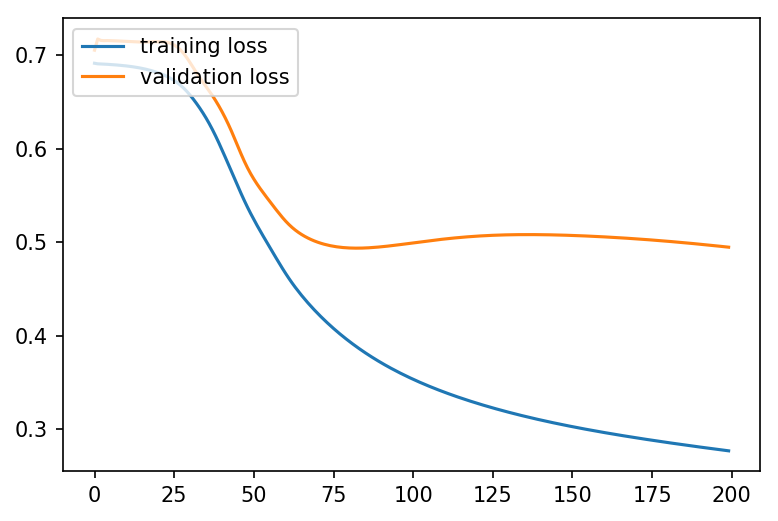

In [18]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(va_loss, label='validation loss')
plt.legend(loc='upper left')
plt.show()